### AMS 520 Kernel Learning Data

In [1]:
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt

orig_path='/home/jbohn/jupyter/personal/TAQ-Query-Scripts/data'
new_path='/home/jbohn/jupyter/personal/Kernel_Learning'
sys.path.append(new_path)

# Data Set
- Trade and Quote Data for AAPL on NASDAQ between 01/02/2020 and 01/29/2020

### Preprocessing
- Removed trades outside of market hours and timestamp realignment


In [3]:
def clean_trades(trades):

    # parse date and pt
    trades["date"] = trades["Time"].apply(lambda x: str(x[:11]))
    trades.index = trades["date"] + trades["Participant_Timestamp"].astype(str)
    trades = trades.drop(columns=["Participant_Timestamp"])
    trades = trades.rename(
        columns={trades.columns[0]: "Participant_Timestamp", "Time": "SIP_Timestamp"}
    )
    
    
    trades.index = trades.index.str[:-3]
    time = pd.Series(
        pd.to_datetime(trades.index.str[11:].str.zfill(12), format="%H%M%S%f")
    )
    date = pd.Series(pd.to_datetime(trades.index.str[:11]))
    trades.index = date.apply(lambda x: x) + time.apply(
        lambda x: timedelta(
            hours=x.hour, minutes=x.minute, seconds=x.second, microseconds=x.microsecond
        )
    )

    trades = trades.sort_index()

    trades = trades.dropna(axis=1, how="all")

    trades=trades[trades['Trade_Volume']>0]
    
    trades=trades[trades['Trade_Price']>0]
    
    grouped_trades = trades.groupby("date").groups

    # drop trade data outside of market hours

    for day in grouped_trades.keys():
        subset = trades[trades["date"] == day]
        grouped_trades[day] = subset[
            subset.index < datetime.strptime(f"{day} 16:00:00", "%Y-%m-%d %H:%M:%S")
        ]
        grouped_trades[day] = subset[
            subset.index > datetime.strptime(f"{day} 09:30:00", "%Y-%m-%d %H:%M:%S")
        ]

    new_trades = pd.concat(list(grouped_trades.values())).sort_index()

    return new_trades



def clean_quotes(quotes, drop_after_hours=True):

    # parse date and pt
    quotes["date"] = quotes["Time"].apply(lambda x: str(x[:11]))
    quotes.index = quotes["date"] + quotes["Participant_Timestamp"].astype(str)
    quotes = quotes.drop(columns=["Participant_Timestamp", "date"])
    quotes = quotes.rename(
        columns={quotes.columns[0]: "Participant_Timestamp", "Time": "SIP_Timestamp"}
    )

    # convert pt to valid ts
    quotes.index = quotes.index.str[:-3]
    time = pd.Series(
        pd.to_datetime(quotes.index.str[11:].str.zfill(12), format="%H%M%S%f")
    )
    date = pd.Series(pd.to_datetime(quotes.index.str[:11]))
    quotes.index = date.apply(lambda x: x) + time.apply(
        lambda x: timedelta(
            hours=x.hour, minutes=x.minute, seconds=x.second, microseconds=x.microsecond
        )
    )

    quotes = quotes.sort_index()

    quotes = quotes.dropna(axis=1, how="all")

    quotes = quotes[
        quotes["Offer_Price"] > quotes["Bid_Price"]
    ]  # removed quotes with invalid spreads
    quotes = quotes[quotes["Bid_Price"] > 0]  # bid and offer price >0

    # drop after hours for quotes, preserve if want to prepend lob
    if drop_after_hours:
        quotes["date"] = quotes.index.date

        grouped_quotes = quotes.groupby("date").groups

        # drop trade data outside of market hours

        for day in grouped_quotes.keys():
            subset = quotes[quotes["date"] == day]
            grouped_quotes[day] = subset[
                subset.index < datetime.strptime(f"{day} 16:00:00", "%Y-%m-%d %H:%M:%S")
            ]
            grouped_quotes[day] = subset[
                subset.index > datetime.strptime(f"{day} 09:30:00", "%Y-%m-%d %H:%M:%S")
            ]
        new_quotes = pd.concat(list(grouped_quotes.values())).sort_index()

        return new_quotes
    else:
        return quotes

### Trade Features


In [6]:
trades=pd.read_csv(f"{orig_path}/AAPL_trades.csv")
trades=trades[trades['Time']<'2020-01-03']
trades=clean_trades(trades)
trades.to_csv(f"{orig_path}/data/cleaned_trades.csv")

In [15]:
sample_trades=trades.copy()
sample_trades

,SIP_Timestamp,Exchange,Symbol,Trade_Volume,Trade_Price,Sale_Condition,Source_of_Trade,Trade_Correction_Indicator,Sequence_Number,Trade_Id,Trade_Reporting_Facility,Trade_Through_Exempt_Indicator,date
2020-01-02 09:30:00.134336,2020-01-02 09:30:00.134553,K,AAPL,250,296.24,@,N,0,19803,1100,,0,2020-01-02
2020-01-02 09:30:00.134371,2020-01-02 09:30:00.134577,K,AAPL,50,296.24,@ I,N,0,19804,1101,,0,2020-01-02
2020-01-02 09:30:00.134532,2020-01-02 09:30:00.134742,K,AAPL,108,296.21,@,N,0,19805,1102,,0,2020-01-02
2020-01-02 09:30:00.157191,2020-01-02 09:30:00.157563,P,AAPL,1,296.28,@F I,N,0,19878,1763,,1,2020-01-02
2020-01-02 09:30:00.157191,2020-01-02 09:30:00.157564,P,AAPL,1,296.28,@ Q,N,0,19879,1764,,0,2020-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02 19:59:52.611412,2020-01-02 19:59:52.611625,K,AAPL,100,301.19,@FT,N,0,3133007,19384,,1,2020-01-02
2020-01-02 19:59:52.611424,2020-01-02 19:59:52.611625,Z,AAPL,100,301.19,@FT,N,0,3133008,32716,,1,2020-01-02
2020-01-02 19:59:57.963903,2020-01-02 19:59:57.964148,K,AAPL,1,301.20,@ TI,N,0,3133022,19385,,1,2020-01-02
2020-01-02 19:59:57.963903,2020-01-02 19:59:57.964161,K,AAPL,70,301.21,@ TI,N,0,3133023,19386,,1,2020-01-02


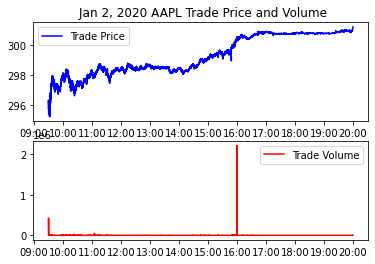

In [16]:
fig,ax=plt.subplots(2,1)
ax[0].plot(sample_trades["Trade_Price"],label='Trade Price',color='blue')
ax[1].plot(sample_trades["Trade_Volume"],label='Trade Volume',color='red')
ax[0].xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax[1].xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax[0].set_title(" Jan 2, 2020 AAPL Trade Price and Volume")
ax[0].legend()
ax[1].legend()

### Examine properties of Trades
    - @ : Regular Trade
    - @F : Regular Intermarket Sweep
    - @I : Regular Odd Lot
    - @IF: Regular Odd Lot Intermarket Sweep

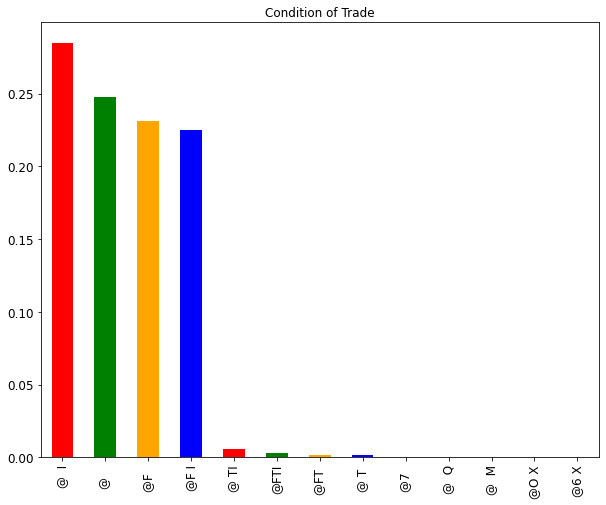

In [17]:
my_colors = c = ['red', 'green', 'orange', 'blue']
ax = (trades['Sale_Condition'].value_counts()/trades.shape[0]).plot(kind='bar', title ="Condition of Trade", figsize=(10,8),  fontsize=12,color=my_colors)

(array([2.0698e+04, 2.0778e+04, 3.5586e+04, 8.2650e+04, 3.3400e+03,
        1.9200e+02, 1.2000e+01, 2.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([ 0.        ,  1.46115906,  2.92231812,  4.38347718,  5.84463624,
         7.3057953 ,  8.76695437, 10.22811343, 11.68927249, 13.15043155,
        14.61159061]),
 <BarContainer object of 10 artists>)

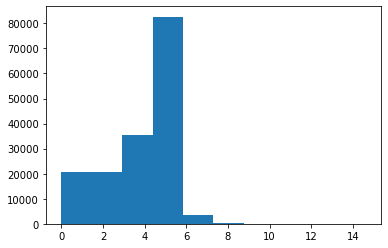

In [10]:
plt.hist(np.log(trades['Trade_Volume']))

### Quote Features

- CleanQuotes correctly aligned according to participant ts

In [4]:
quotes=pd.read_csv(f"{orig_path}/AAPL_quotes_2020-01-02.csv")
quotes=quotes[quotes['Time']<'2020-01-03']
quotes=clean_quotes(quotes)
#quotes.to_csv(f"{orig_path}/data/cleaned_quotes.csv")

In [5]:
quotes


,Participant_Timestamp,SIP_Timestamp,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size,Quote_Condition,Sequence_Number,...,Best_Bid_Exchange,Best_Bid_Price,Best_Bid_Size,Best_Offer_Exchange,Best_Offer_Price,Best_Offer_Size,LULD_NBBO_Indicator,Security_Status_Indicator,National_BBO_Ind,date
2020-01-02 09:30:03.296828,140,2020-01-02 09:30:03.297207,N,AAPL,295.70,1.0,296.75,6.0,R,288805,...,Q,296.19,2.0,Z,296.26,2.0,A,,2,2020-01-02
2020-01-02 09:30:05.489204,141,2020-01-02 09:30:05.489581,N,AAPL,296.14,4.0,296.75,5.0,R,296557,...,N,296.14,4.0,Z,296.19,4.0,A,,2,2020-01-02
2020-01-02 09:30:05.663684,142,2020-01-02 09:30:05.664062,N,AAPL,295.70,1.0,296.75,5.0,R,297100,...,Q,296.13,1.0,Z,296.16,2.0,A,,2,2020-01-02
2020-01-02 09:30:06.278858,143,2020-01-02 09:30:06.279237,N,AAPL,294.05,1.0,296.12,2.0,R,299138,...,Q,296.03,1.0,Z,296.07,4.0,A,,2,2020-01-02
2020-01-02 09:30:14.710996,144,2020-01-02 09:30:14.711372,N,AAPL,295.12,1.0,295.74,1.0,R,318631,...,Z,295.65,6.0,N,295.74,1.0,A,,2,2020-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02 15:59:41.175398,87570,2020-01-02 15:59:41.175774,N,AAPL,300.41,2.0,300.66,1.0,R,30603857,...,Z,300.41,3.0,Q,300.44,4.0,A,,2,2020-01-02
2020-01-02 15:59:46.113982,87571,2020-01-02 15:59:46.114358,N,AAPL,300.29,3.0,300.46,1.0,R,30643992,...,Z,300.44,2.0,P,300.46,2.0,A,,2,2020-01-02
2020-01-02 15:59:50.118942,87572,2020-01-02 15:59:50.119320,N,AAPL,300.29,3.0,300.66,1.0,R,30672299,...,Q,300.37,3.0,Q,300.40,4.0,A,,2,2020-01-02
2020-01-02 15:59:52.913707,87573,2020-01-02 15:59:52.914082,N,AAPL,300.29,3.0,300.66,1.0,R,30696052,...,Q,300.36,1.0,Q,300.39,2.0,A,,2,2020-01-02


In [6]:
sample_quotes=quotes.copy()

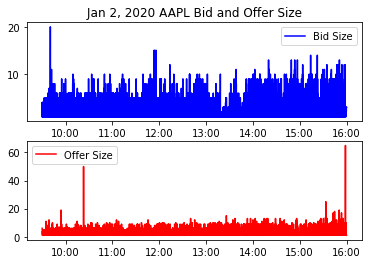

In [7]:
fig,ax=plt.subplots(2,1)
ax[0].plot(sample_quotes['Bid_Size'],label='Bid Size',color='blue')
ax[1].plot(sample_quotes['Offer_Size'],label='Offer Size',color='red')
ax[0].xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax[1].xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax[0].set_title(" Jan 2, 2020 AAPL Bid and Offer Size ")
ax[0].legend()
ax[1].legend()

### Bulk Data Cleaning

In [8]:
from Data.clean_data import clean_quotes, clean_trades
import pandas as pd

start='2020-01-01'
end='2020-01-29'
dts=pd.date_range(start=start,end=end,freq='D')
dts


DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29'],
              dtype='datetime64[ns]', freq='D')

In [10]:
for dt in dts:
    str_dt=str(dt.date())
    quotes=pd.read_csv(f"{orig_path}/AAPL_quotes_{str_dt}.csv")
    if len(quotes)>0:
        quotes=clean_quotes(quotes)
        quotes.to_csv(f"{new_path}/Data/cleaned_AAPL_quotes_{str_dt}.csv")
        print(f"Quotes for {str_dt} cleaned")


Quotes for 2020-01-02 cleaned
Quotes for 2020-01-03 cleaned
Quotes for 2020-01-06 cleaned
Quotes for 2020-01-07 cleaned
Quotes for 2020-01-08 cleaned
Quotes for 2020-01-09 cleaned
Quotes for 2020-01-10 cleaned
Quotes for 2020-01-13 cleaned
Quotes for 2020-01-14 cleaned
Quotes for 2020-01-15 cleaned
Quotes for 2020-01-16 cleaned
Quotes for 2020-01-17 cleaned
Quotes for 2020-01-21 cleaned
Quotes for 2020-01-22 cleaned
Quotes for 2020-01-23 cleaned
Quotes for 2020-01-24 cleaned
Quotes for 2020-01-27 cleaned
Quotes for 2020-01-28 cleaned
Quotes for 2020-01-29 cleaned
